<a href="https://colab.research.google.com/github/SiddanshChawla/stock_forecasting/blob/main/bi_lstm_for_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import re   
import nltk  
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

In [ ]:
data = pd.read_csv('/content/financial news data.csv',encoding='latin-1',header = None)

In [ ]:
data.head()

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
data.columns = ['sentiment', 'news']

In [ ]:
data

,sentiment,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


<Axes: xlabel='sentiment'>

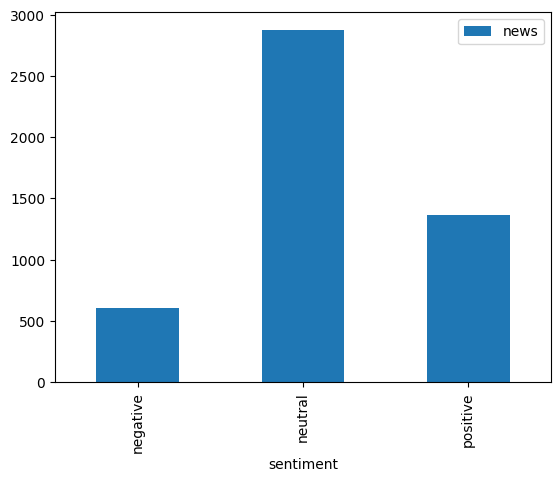

In [ ]:
data.groupby('sentiment').count().plot(kind='bar')


In [ ]:
def headlines_to_words(news):   
    news = news.lower()
    news = re.sub(r"[^a-zA-Z0-9]", " ", news)
    words = news.split()
    words = [w for w in words if w not in stopwords.words("english")]
    words = [PorterStemmer().stem(w) for w in words]
    return words

print("\nOriginal tweet ->", data['news'][0])
print("\nProcessed tweet ->", headlines_to_words(data['news'][0]))


Original tweet -> According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

Processed tweet -> ['accord', 'gran', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'compani', 'grow']


In [ ]:
X = list(map(headlines_to_words, data['news']))


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y = le.fit_transform(data['sentiment'])

In [ ]:
print(X[0])
print(Y[0])

['accord', 'gran', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'compani', 'grow']
1


In [ ]:
y = pd.get_dummies(data['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:

vocabulary_size = 5000

count_vector = CountVectorizer(max_features=vocabulary_size,preprocessor=lambda x: x,tokenizer=lambda x: x) 
X_train = count_vector.fit_transform(X_train).toarray()
X_test = count_vector.transform(X_test).toarray()

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
max_words = 1000
max_len=50

def tokenize_pad_sequences(text):
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

X, tokenizer = tokenize_pad_sequences(data['news'])


In [ ]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
y = pd.get_dummies(data['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (2907, 50) (2907, 3)
Validation Set -> (969, 50) (969, 3)
Test Set -> (970, 50) (970, 3)


In [ ]:

vocab_size = 1000
embedding_size = 40
epochs=23
learning_rate = 0.3
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

batch_size = 64
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 40)            40000     
                                                                 
 conv1d_7 (Conv1D)           (None, 50, 32)            3872      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)


print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))


Accuracy  : 0.7010
Precision : 0.7093
Recall    : 0.6742
